In [48]:
import pandas as pd
import json
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder

#Libraries for multiple regression which I will use for model comparison
from sklearn import linear_model

In [2]:
df = pd.read_csv("best_ever_costs.csv")
df.head()

,material,per_unit_cost,quantity,complexity_score,surface_area,bounding_box_volume,volume,max_x_length,max_y_length,max_z_length,optimal_fit_on_hp_build_plate
0,ABS-M30,30.67,2,8.951051,"{""units"": ""in^2/"", ""value"": 30.86906387028813}","{""units"": ""in^3/"", ""value"": 21.753358840942383}","{""units"": ""in^3/"", ""value"": 2.392122115044577}","{""units"": ""in"", ""value"": 7.431044101715088}","{""units"": ""in"", ""value"": 2.342428207397461}","{""units"": ""in"", ""value"": 1.2497128248214722}",1046.0
1,ABS-M30,644.38,3,9.128668,"{""units"": ""mm^2/"", ""value"": 751674.309321575}","{""units"": ""mm^3/"", ""value"": 5456805.5}","{""units"": ""mm^3/"", ""value"": 886843.7309218515}","{""units"": ""mm"", ""value"": 484.1076354980469}","{""units"": ""mm"", ""value"": 387.3500061035156}","{""units"": ""mm"", ""value"": 29.099998474121094}",46.0
2,ABS-M30,853.24,3,7.884523,"{""units"": ""mm^2/"", ""value"": 1004271.6988237221}","{""units"": ""mm^3/"", ""value"": 10672181.0}","{""units"": ""mm^3/"", ""value"": 1298836.9205762406}","{""units"": ""mm"", ""value"": 584.1876831054688}","{""units"": ""mm"", ""value"": 487.15765380859375}","{""units"": ""mm"", ""value"": 37.5}",31.0
3,ABS-M30,638.75,3,9.892117,"{""units"": ""mm^2/"", ""value"": 770573.781450489}","{""units"": ""mm^3/"", ""value"": 6037922.5}","{""units"": ""mm^3/"", ""value"": 917936.479691732}","{""units"": ""mm"", ""value"": 484.1076354980469}","{""units"": ""mm"", ""value"": 387.337646484375}","{""units"": ""mm"", ""value"": 32.20000076293945}",44.0
4,Ultem 1010,63.88,10,8.704826,"{""units"": ""mm^2/"", ""value"": 25472.59762170911}","{""units"": ""mm^3/"", ""value"": 335400}","{""units"": ""mm^3/"", ""value"": 85285.97260241448}","{""units"": ""mm"", ""value"": 100.0}","{""units"": ""mm"", ""value"": 129.0}","{""units"": ""mm"", ""value"": 26.0}",480.0


In [3]:
df.shape

(1076, 11)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1076 entries, 0 to 1075
Data columns (total 11 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   material                       1076 non-null   object 
 1   per_unit_cost                  1076 non-null   float64
 2   quantity                       1076 non-null   int64  
 3   complexity_score               832 non-null    float64
 4   surface_area                   1076 non-null   object 
 5   bounding_box_volume            1076 non-null   object 
 6   volume                         1076 non-null   object 
 7   max_x_length                   1076 non-null   object 
 8   max_y_length                   1076 non-null   object 
 9   max_z_length                   1076 non-null   object 
 10  optimal_fit_on_hp_build_plate  798 non-null    float64
dtypes: float64(3), int64(1), object(7)
memory usage: 92.6+ KB


In [5]:
#Before I check for outliers or missing values, I have to address certain columns first
#Some columns have units and text before the actual values I want, so I'm going to remove everything that's 
#preceding these values

#I noticed much later that the units aren't standard, so I will convert them all into inches a bit later,
#after I have the chance to take a look at the missing values
df["surface_area_num"] = df["surface_area"].apply(lambda x: json.loads(x)["value"])
df["bounding_box_volume_num"] = df["bounding_box_volume"].apply(lambda x: json.loads(x)["value"])
df["volume_num"] = df["volume"].apply(lambda x: json.loads(x)["value"])
df["max_x_length_num"] = df["max_x_length"].apply(lambda x: json.loads(x)["value"])
df["max_y_length_num"] = df["max_y_length"].apply(lambda x: json.loads(x)["value"])
df["max_z_length_num"] = df["max_z_length"].apply(lambda x: json.loads(x)["value"])


In [6]:
df.head()

,material,per_unit_cost,quantity,complexity_score,surface_area,bounding_box_volume,volume,max_x_length,max_y_length,max_z_length,optimal_fit_on_hp_build_plate,surface_area_num,bounding_box_volume_num,volume_num,max_x_length_num,max_y_length_num,max_z_length_num
0,ABS-M30,30.67,2,8.951051,"{""units"": ""in^2/"", ""value"": 30.86906387028813}","{""units"": ""in^3/"", ""value"": 21.753358840942383}","{""units"": ""in^3/"", ""value"": 2.392122115044577}","{""units"": ""in"", ""value"": 7.431044101715088}","{""units"": ""in"", ""value"": 2.342428207397461}","{""units"": ""in"", ""value"": 1.2497128248214722}",1046.0,3.086906e+01,2.175336e+01,2.392122e+00,7.431044,2.342428,1.249713
1,ABS-M30,644.38,3,9.128668,"{""units"": ""mm^2/"", ""value"": 751674.309321575}","{""units"": ""mm^3/"", ""value"": 5456805.5}","{""units"": ""mm^3/"", ""value"": 886843.7309218515}","{""units"": ""mm"", ""value"": 484.1076354980469}","{""units"": ""mm"", ""value"": 387.3500061035156}","{""units"": ""mm"", ""value"": 29.099998474121094}",46.0,7.516743e+05,5.456806e+06,8.868437e+05,484.107635,387.350006,29.099998
2,ABS-M30,853.24,3,7.884523,"{""units"": ""mm^2/"", ""value"": 1004271.6988237221}","{""units"": ""mm^3/"", ""value"": 10672181.0}","{""units"": ""mm^3/"", ""value"": 1298836.9205762406}","{""units"": ""mm"", ""value"": 584.1876831054688}","{""units"": ""mm"", ""value"": 487.15765380859375}","{""units"": ""mm"", ""value"": 37.5}",31.0,1.004272e+06,1.067218e+07,1.298837e+06,584.187683,487.157654,37.500000
3,ABS-M30,638.75,3,9.892117,"{""units"": ""mm^2/"", ""value"": 770573.781450489}","{""units"": ""mm^3/"", ""value"": 6037922.5}","{""units"": ""mm^3/"", ""value"": 917936.479691732}","{""units"": ""mm"", ""value"": 484.1076354980469}","{""units"": ""mm"", ""value"": 387.337646484375}","{""units"": ""mm"", ""value"": 32.20000076293945}",44.0,7.705738e+05,6.037922e+06,9.179365e+05,484.107635,387.337646,32.200001
4,Ultem 1010,63.88,10,8.704826,"{""units"": ""mm^2/"", ""value"": 25472.59762170911}","{""units"": ""mm^3/"", ""value"": 335400}","{""units"": ""mm^3/"", ""value"": 85285.97260241448}","{""units"": ""mm"", ""value"": 100.0}","{""units"": ""mm"", ""value"": 129.0}","{""units"": ""mm"", ""value"": 26.0}",480.0,2.547260e+04,3.354000e+05,8.528597e+04,100.000000,129.000000,26.000000


In [7]:
#Still have to change "material" column 
#All other object columns that aren't "material" will get dropped later, so they won't cause an issue
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1076 entries, 0 to 1075
Data columns (total 17 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   material                       1076 non-null   object 
 1   per_unit_cost                  1076 non-null   float64
 2   quantity                       1076 non-null   int64  
 3   complexity_score               832 non-null    float64
 4   surface_area                   1076 non-null   object 
 5   bounding_box_volume            1076 non-null   object 
 6   volume                         1076 non-null   object 
 7   max_x_length                   1076 non-null   object 
 8   max_y_length                   1076 non-null   object 
 9   max_z_length                   1076 non-null   object 
 10  optimal_fit_on_hp_build_plate  798 non-null    float64
 11  surface_area_num               832 non-null    float64
 12  bounding_box_volume_num        832 non-null    f

In [8]:
#Want to see how many unique values there are for "material", and will then create a new column that
#assigns values to each unique input
pd.unique(df["material"])

array(['ABS-M30', 'Ultem 1010', 'PPSF', 'Nylon 12', 'ASA', 'ABS', 'PC',
       'Ultem 9085', 'PC-ABS', 'PC-ISO', 'ST-130', 'ABS-ESD7', 'Pekk',
       'Nylon 12CF', 'Nylon 6', 'ABS-M30i'], dtype=object)

In [9]:
#Used LabelEncoder() to assign numerical values to categorical
encoder = LabelEncoder()
df["material"] = encoder.fit_transform(df["material"])  


In [10]:
#Make sure "material" is now an int dtype
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1076 entries, 0 to 1075
Data columns (total 17 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   material                       1076 non-null   int64  
 1   per_unit_cost                  1076 non-null   float64
 2   quantity                       1076 non-null   int64  
 3   complexity_score               832 non-null    float64
 4   surface_area                   1076 non-null   object 
 5   bounding_box_volume            1076 non-null   object 
 6   volume                         1076 non-null   object 
 7   max_x_length                   1076 non-null   object 
 8   max_y_length                   1076 non-null   object 
 9   max_z_length                   1076 non-null   object 
 10  optimal_fit_on_hp_build_plate  798 non-null    float64
 11  surface_area_num               832 non-null    float64
 12  bounding_box_volume_num        832 non-null    f

In [11]:
#Now I can check for outliers and missing values
df.isna().sum()

material                           0
per_unit_cost                      0
quantity                           0
complexity_score                 244
surface_area                       0
bounding_box_volume                0
volume                             0
max_x_length                       0
max_y_length                       0
max_z_length                       0
optimal_fit_on_hp_build_plate    278
surface_area_num                 244
bounding_box_volume_num          244
volume_num                       244
max_x_length_num                 244
max_y_length_num                 244
max_z_length_num                 244
dtype: int64

In [12]:
#What percentage is missing for each column
missing_values = df.isna().sum()
all_values = df.isna().count()
percent = round(missing_values / all_values * 100, 1)
print(percent)

material                          0.0
per_unit_cost                     0.0
quantity                          0.0
complexity_score                 22.7
surface_area                      0.0
bounding_box_volume               0.0
volume                            0.0
max_x_length                      0.0
max_y_length                      0.0
max_z_length                      0.0
optimal_fit_on_hp_build_plate    25.8
surface_area_num                 22.7
bounding_box_volume_num          22.7
volume_num                       22.7
max_x_length_num                 22.7
max_y_length_num                 22.7
max_z_length_num                 22.7
dtype: float64


In [13]:
#Normally for any data that's missing a relatively large number of values, 
#I would try to find out why the values are missing before deciding how to proceed.
#I would either fill them in with the column average, or 0, or impute the missing data from what is there,
#depending on the situation.
#However, in this case, all the missing values are from the same row, which means
#that each of these rows is missing ~73% of data. 
#Because of this, it seems most appropriate to drop all of these mostly empty rows.
df = df.dropna(subset = ["volume_num"])

In [14]:
#Check percentage again
missing_values = df.isna().sum()
all_values = df.isna().count()
percent = round(missing_values / all_values * 100, 1)
print(percent)

material                         0.0
per_unit_cost                    0.0
quantity                         0.0
complexity_score                 0.0
surface_area                     0.0
bounding_box_volume              0.0
volume                           0.0
max_x_length                     0.0
max_y_length                     0.0
max_z_length                     0.0
optimal_fit_on_hp_build_plate    4.1
surface_area_num                 0.0
bounding_box_volume_num          0.0
volume_num                       0.0
max_x_length_num                 0.0
max_y_length_num                 0.0
max_z_length_num                 0.0
dtype: float64


In [15]:
df.describe()

,material,per_unit_cost,quantity,complexity_score,optimal_fit_on_hp_build_plate,surface_area_num,bounding_box_volume_num,volume_num,max_x_length_num,max_y_length_num,max_z_length_num
count,832.000000,832.000000,832.000000,832.000000,7.980000e+02,8.320000e+02,8.320000e+02,8.320000e+02,832.000000,832.000000,832.000000
mean,4.610577,290.829026,142.737981,8.225256,1.987327e+05,1.084456e+05,3.386918e+06,4.870516e+05,139.548337,89.905460,85.951751
std,4.960473,886.553697,908.506353,1.512760,1.738396e+06,2.479420e+05,1.363711e+07,2.785420e+06,188.881796,114.555983,126.173480
min,0.000000,0.490000,1.000000,0.000000,0.000000e+00,3.742092e+00,5.157359e-01,7.065584e-02,0.187875,0.187008,0.244181
25%,0.000000,20.930000,1.000000,7.585075,1.200000e+01,7.730047e+02,1.057144e+03,1.614617e+02,15.000000,9.300000,6.312695
50%,2.000000,76.000000,2.000000,8.903856,1.750000e+02,2.143204e+04,2.283920e+05,3.157791e+04,68.692703,45.749907,32.000000
75%,8.000000,256.000000,15.000000,9.079046,1.039000e+03,9.291385e+04,1.612816e+06,2.102480e+05,169.849258,126.400711,122.480072
max,15.000000,18967.000000,10000.000000,10.332533,3.245873e+07,2.036717e+06,1.791115e+08,4.397511e+07,1478.026001,884.906982,1478.026001


In [16]:
#Now only one column is missing 4.1% of data, which we can easily fill in without causing too many problems 
#I checked the mean and standard deviation above, and since they aren't too far off from each other, that tells
#me that filling in the remaining missing values with the mean is a good approach.
#If the mean and std weren't close, I would try something different, like .interpolate() for example.
average = df["optimal_fit_on_hp_build_plate"].mean()
df["optimal_fit_on_hp_build_plate"].fillna(value = average, inplace = True)

In [17]:
#Everything should be 0 now
missing_values = df.isna().sum()
all_values = df.isna().count()
percent = round(missing_values / all_values * 100, 1)
print(percent)

material                         0.0
per_unit_cost                    0.0
quantity                         0.0
complexity_score                 0.0
surface_area                     0.0
bounding_box_volume              0.0
volume                           0.0
max_x_length                     0.0
max_y_length                     0.0
max_z_length                     0.0
optimal_fit_on_hp_build_plate    0.0
surface_area_num                 0.0
bounding_box_volume_num          0.0
volume_num                       0.0
max_x_length_num                 0.0
max_y_length_num                 0.0
max_z_length_num                 0.0
dtype: float64


In [18]:
#I now need to address the values which are recoded in inches and mm.
#I want to standardize them so that they're all in same units.
#I will convert everything to inches.
#First, I will create two new columns for each existing column that needs to be converted, where one new
#column is just the units, and another just the measurements.
#Then I will use the first column to decide if I should convert or leave it as is, and then I will drop
#the unit columns since now everything will be in inches and they will no longer be necessary.
#This is not the most elegant approach, but it works....

#Create two columns for each:
df['surface_area_units'] = df['surface_area'].apply(lambda x: json.loads(x)['units'])
df['surface_area_value'] = df['surface_area'].apply(lambda x: json.loads(x)['value'])
df['bounding_box_volume_units'] = df['bounding_box_volume'].apply(lambda x: json.loads(x)['units'])
df['bounding_box_volume_value'] = df['bounding_box_volume'].apply(lambda x: json.loads(x)['value'])
df['max_x_length_units'] = df['max_x_length'].apply(lambda x: json.loads(x)['units'])
df['max_x_length_value'] = df['max_x_length'].apply(lambda x: json.loads(x)['value'])
df['volume_units'] = df['volume'].apply(lambda x: json.loads(x)['units'])
df['volume_value'] = df['volume'].apply(lambda x: json.loads(x)['value'])
df['max_y_length_units'] = df['max_y_length'].apply(lambda x: json.loads(x)['units'])
df['max_y_length_value'] = df['max_y_length'].apply(lambda x: json.loads(x)['value'])
df['max_z_length_units'] = df['max_z_length'].apply(lambda x: json.loads(x)['units'])
df['max_z_length_value'] = df['max_z_length'].apply(lambda x: json.loads(x)['value'])

#Convert all the mm units
df.loc[df["surface_area_units"] == "mm^2/", "surface_area_value"] *= 25.4
df.loc[df["bounding_box_volume_units"] == "mm^3", "bounding_box_volume_value"] *= 25.4
df.loc[df["max_x_length_units"] == "mm", "max_x_length_value"] *= 25.4
df.loc[df["max_y_length_units"] == "mm", "max_y_length_value"] *= 25.4
df.loc[df["max_z_length_units"] == "mm", "max_z_length_value"] *= 25.4
df.loc[df["volume_units"] == "mm^3", "volume_value"] *= 25.4

In [19]:
#Drop all the columns we no longer need
df = df.drop(["surface_area", 
              "bounding_box_volume", 
              "volume", 
              "max_x_length", 
              "max_y_length", 
              "max_z_length",
              "surface_area_units",
              "bounding_box_volume_units",
              "max_x_length_units",
              "max_y_length_units",
              "max_z_length_units",
              "volume_units",
              "surface_area_num",
              "bounding_box_volume_num",
              "volume_num",
              "max_x_length_num",
              "max_y_length_num",
              "max_z_length_num"], axis = 1)

In [20]:
#We should now just have numerical columns for all the measurements, in inches
df.head()

,material,per_unit_cost,quantity,complexity_score,optimal_fit_on_hp_build_plate,surface_area_value,bounding_box_volume_value,max_x_length_value,volume_value,max_y_length_value,max_z_length_value
0,2,30.67,2,8.951051,1046.0,3.086906e+01,2.175336e+01,7.431044,2.392122e+00,2.342428,1.249713
1,2,644.38,3,9.128668,46.0,1.909253e+07,5.456806e+06,12296.333942,8.868437e+05,9838.690155,739.139961
2,2,853.24,3,7.884523,31.0,2.550850e+07,1.067218e+07,14838.367151,1.298837e+06,12373.804407,952.500000
3,2,638.75,3,9.892117,44.0,1.957257e+07,6.037922e+06,12296.333942,9.179365e+05,9838.376221,817.880019
4,14,63.88,10,8.704826,480.0,6.470040e+05,3.354000e+05,2540.000000,8.528597e+04,3276.600000,660.400000


In [21]:
#Check to make sure everything is numeric
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 832 entries, 0 to 1069
Data columns (total 11 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   material                       832 non-null    int64  
 1   per_unit_cost                  832 non-null    float64
 2   quantity                       832 non-null    int64  
 3   complexity_score               832 non-null    float64
 4   optimal_fit_on_hp_build_plate  832 non-null    float64
 5   surface_area_value             832 non-null    float64
 6   bounding_box_volume_value      832 non-null    float64
 7   max_x_length_value             832 non-null    float64
 8   volume_value                   832 non-null    float64
 9   max_y_length_value             832 non-null    float64
 10  max_z_length_value             832 non-null    float64
dtypes: float64(9), int64(2)
memory usage: 78.0 KB


In [22]:
#Want to address the extreme outliers
df.describe()

,material,per_unit_cost,quantity,complexity_score,optimal_fit_on_hp_build_plate,surface_area_value,bounding_box_volume_value,max_x_length_value,volume_value,max_y_length_value,max_z_length_value
count,832.000000,832.000000,832.000000,832.000000,8.320000e+02,8.320000e+02,8.320000e+02,832.000000,8.320000e+02,832.000000,832.000000
mean,4.610577,290.829026,142.737981,8.225256,1.987327e+05,2.279997e+06,3.386918e+06,2730.395935,4.870516e+05,1734.247058,1679.074721
std,4.960473,886.553697,908.506353,1.512760,1.702462e+06,6.156429e+06,1.363711e+07,3738.721283,2.785420e+06,2458.348178,2828.391127
min,0.000000,0.490000,1.000000,0.000000,0.000000e+00,3.742092e+00,5.157359e-01,0.187875,7.065584e-02,0.187008,0.244181
25%,0.000000,20.930000,1.000000,7.585075,1.450000e+01,3.004244e+03,1.057144e+03,43.783251,1.614617e+02,44.450001,23.240999
50%,2.000000,76.000000,2.000000,8.903856,1.990000e+02,2.491461e+05,2.283920e+05,1313.358884,3.157791e+04,711.778502,387.082284
75%,8.000000,256.000000,15.000000,9.079046,1.658000e+03,1.430321e+06,1.612816e+06,3539.526006,2.102480e+05,2635.250000,1949.435854
max,15.000000,18967.000000,10000.000000,10.332533,3.245873e+07,5.173261e+07,1.791115e+08,22580.600000,4.397511e+07,22476.637354,18826.480310


In [23]:
#There are a few columns with extreme outliers 
#**Explain this more**
maximum = df["per_unit_cost"].quantile(0.9)
df = df[df["per_unit_cost"] < maximum]

maximum2 = df["quantity"].quantile(0.9)
df = df[df["quantity"] < maximum2]

In [24]:
#The maximums for these two columns should be less extreme now
df.describe()

,material,per_unit_cost,quantity,complexity_score,optimal_fit_on_hp_build_plate,surface_area_value,bounding_box_volume_value,max_x_length_value,volume_value,max_y_length_value,max_z_length_value
count,649.000000,649.000000,649.000000,649.000000,6.490000e+02,6.490000e+02,6.490000e+02,649.000000,6.490000e+02,649.000000,649.000000
mean,4.545455,135.566795,5.796610,8.264733,2.472574e+05,1.315316e+06,1.425333e+06,2324.858194,1.964901e+05,1517.249474,1370.971492
std,4.806263,159.642892,8.103797,1.447626,1.924607e+06,2.918755e+06,3.600304e+06,3271.842497,5.145940e+05,2053.043600,2218.516522
min,0.000000,0.590000,1.000000,0.000000,0.000000e+00,3.742092e+00,5.157359e-01,0.187875,7.065584e-02,0.187008,0.244181
25%,1.000000,24.000000,1.000000,7.706224,2.200000e+01,9.179412e+02,2.328836e+02,24.417053,4.517201e+01,14.828904,9.644070
50%,2.000000,68.280000,2.000000,8.925279,2.480000e+02,2.125841e+05,2.157659e+05,1063.251283,2.472829e+04,542.289961,325.120005
75%,8.000000,183.470000,8.000000,9.046380,1.658000e+03,1.241014e+06,1.199930e+06,3048.050772,1.532640e+05,2568.727510,1949.435466
max,15.000000,676.000000,41.000000,10.332533,3.245873e+07,3.263448e+07,4.961630e+07,22580.600000,7.986477e+06,15235.274707,14354.809070


<AxesSubplot:>

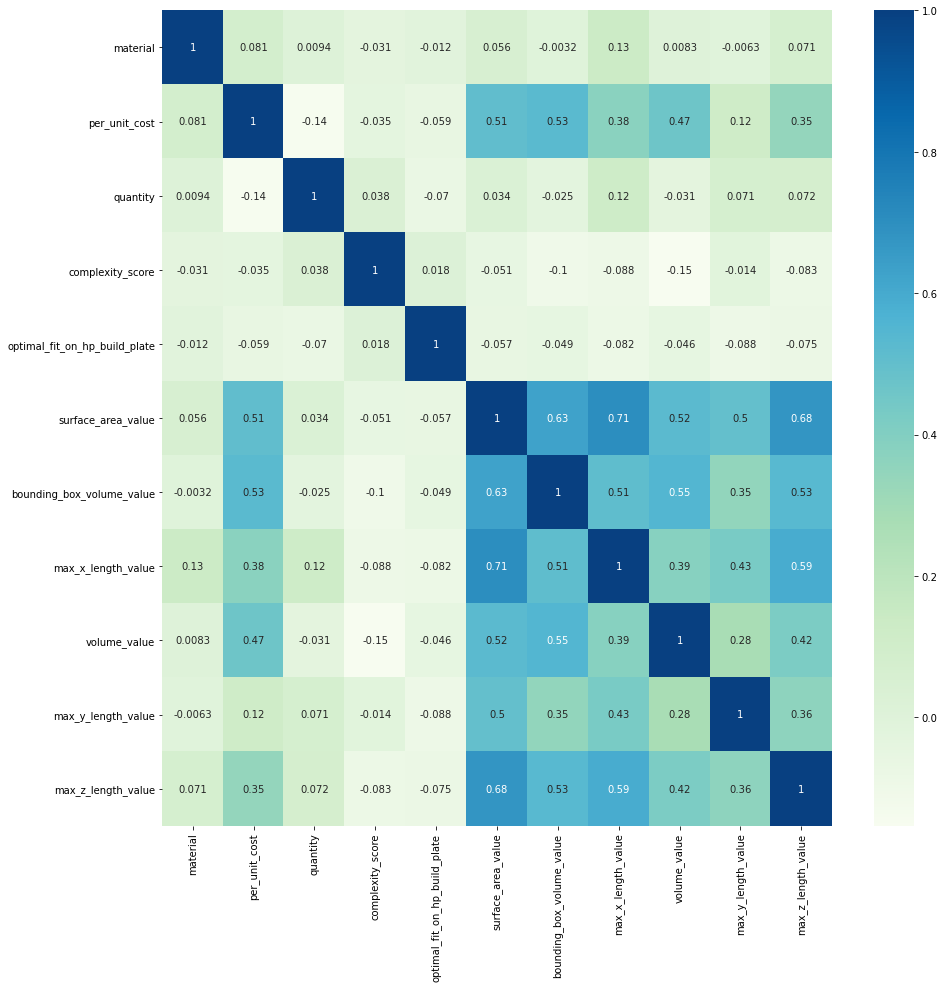

In [25]:
#I will not scale the data since I plan on using the decision tree model. 
#Also, I don't know how the problem/data will scale
plt.figure(1, figsize = (15, 15))
correlation = df.corr()
sns.heatmap(correlation, cmap = "GnBu", annot = True)

#Should ideally use L1 Regularization for feature selection

In [26]:
#No columns seem to be highly correlated, so I will keep all of them
#Now that data has been cleaned, I can now apply the ML model
X = df.iloc[:, df.columns != "per_unit_cost"]

y = df["per_unit_cost"]

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
model = DecisionTreeRegressor(random_state = 100)
model.fit(X_train, y_train)

DecisionTreeRegressor(random_state=100)

In [28]:
y_pred = model.predict(X_test)

In [29]:
df = pd.DataFrame({"Actual": y_test, "Predicted": y_pred})
df

,Actual,Predicted
1049,611.00,520.000
258,3.95,2.610
955,1.40,1.400
589,121.61,130.000
88,18.15,23.670
...,...,...
383,44.00,39.000
303,472.55,476.670
161,184.00,134.540
332,8.04,6.145


In [30]:
#Realistically, these values are mostly useful in terms of deciding the split during the model training.
#They don't mean anything on their own,but are useful as comparison when trying to decide which model to use
print("Mean Absolute Error: ", metrics.mean_absolute_error(y_test, y_pred))
print("Mean Square Error: ", metrics.mean_squared_error(y_test, y_pred))
print("Root Mean Square Error: ", np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error:  36.69378632478633
Mean Square Error:  5498.528473262109
Root Mean Square Error:  74.1520631760311


In [31]:
model.score(X_test, y_test)

0.7955223039778712

# Multiple Regression Model

Will use a multiple regression model to see if it performs better than a decision tree and will use those results to decide which model to apply

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [33]:
regr = linear_model.LinearRegression()
regr.fit(X, y)

LinearRegression()

In [34]:
y_pred = regr.predict(X_test)

In [35]:
df = pd.DataFrame({"Actual": y_test, "Predicted": y_pred})


In [36]:
df

,Actual,Predicted
1049,611.00,856.408652
258,3.95,115.782444
955,1.40,88.460416
589,121.61,121.628702
88,18.15,109.523777
...,...,...
383,44.00,112.394144
303,472.55,221.680734
161,184.00,174.643990
332,8.04,144.340325


In [37]:
print("Mean Absolute Error: ", metrics.mean_absolute_error(y_test, y_pred))
print("Mean Square Error: ", metrics.mean_squared_error(y_test, y_pred))
print("Root Mean Square Error: ", np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error:  87.51354639586074
Mean Square Error:  17197.464681762824
Root Mean Square Error:  131.1391043196606


In [38]:
#Comparing the outputs for the multiple linear regression and the decision tree regression, the decision tree
#gives more accurate outputs, so that is the model I will be using
#If this was a real work problem, I would consider using other mothels

In [39]:
regr.score(X_test, y_test)

0.3604656277313838

# Random Forest

In [40]:
from sklearn.ensemble import RandomForestRegressor

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [42]:
clf = RandomForestRegressor(n_estimators = 1000, min_samples_split = 2)
clf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=1000)

In [43]:
y_pred = clf.predict(X_test)
df = pd.DataFrame({"Actual": y_test, "Predicted": y_pred})
df

,Actual,Predicted
1049,611.00,495.191660
258,3.95,17.442421
955,1.40,1.601020
589,121.61,148.976145
88,18.15,22.261420
...,...,...
383,44.00,49.556620
303,472.55,407.551190
161,184.00,166.899078
332,8.04,10.650287


In [44]:
clf.score(X_test, y_test)

0.8298359602732097

In [45]:
print("Mean Absolute Error: ", metrics.mean_absolute_error(y_test, y_pred))
print("Mean Square Error: ", metrics.mean_squared_error(y_test, y_pred))
print("Root Mean Square Error: ", np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error:  38.619962163573526
Mean Square Error:  4575.8135765663355
Root Mean Square Error:  67.6447601560264
